# 使用预训练的convnet

想要将深度学习应用于一个小型图像数据集，一种常用且非常高效的方法是使用预训练网络。

**预训练网络（pretrained network）**是一个保存好的网络，之前在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。

这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小型数据集问题非常有效。

**使用预训练网络有两种方法：**
1. 特征提取（feature extraction）
2. 微调模型（fine tunning）

## 特征提取

**特征提取**是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入到一个新分类器中，从头开始训练。

对于卷积神经网络来说，特征提取就是取出之前训练好的网络的卷积基（convolutional base），在上面运行新数据，然后在输出上面训练一个新的分类器。

In [1]:
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# 将VGG16卷积基实例化
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 不使用数据增强的快速特征提取

在数据集上运行卷积基，将输出保存成硬盘中的NumPy数组，然后用这个数据作为输入，输入到独立的密集连接分类器中。不允许使用数据增强。

In [4]:
# 使用预训练的卷积基提取特征
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/bingli/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 将图像处理成NumPy数组
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features.shape

(2000, 4, 4, 512)

In [6]:
# 展平
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
# 密集连接分类器
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# Fit the model
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 630us/step - loss: 0.6074 - acc: 0.6585 - val_loss: 0.4342 - val_acc: 0.8420
Epoch 2/30
2000/2000 [==============================] - 1s 469us/step - loss: 0.4190 - acc: 0.8250 - val_loss: 0.3586 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.3552 - acc: 0.8420 - val_loss: 0.3243 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 1s 372us/step - loss: 0.3222 - acc: 0.8710 - val_loss: 0.3040 - val_acc: 0.8750
Epoch 5/30
2000/2000 [==============================] - 1s 373us/step - loss: 0.2785 - acc: 0.8875 - val_loss: 0.2847 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 1s 399us/step - loss: 0.2652 - acc: 0.8895 - val_loss: 0.2795 - val_acc: 0.8820
Epoch 7/30
2000/2000 [==============================] - 1s 391us/step - loss: 0.2545 - acc: 0.8995 - val_loss: 0.2706 - val_acc: 0.8920


> 训练速度非常快。

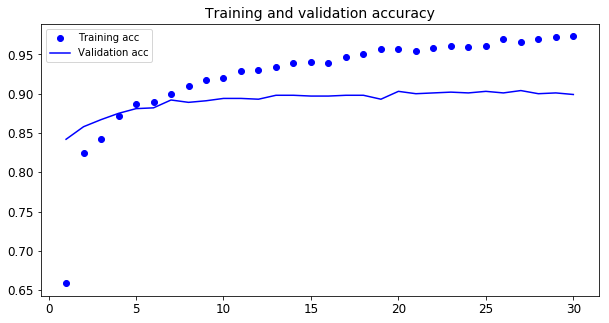

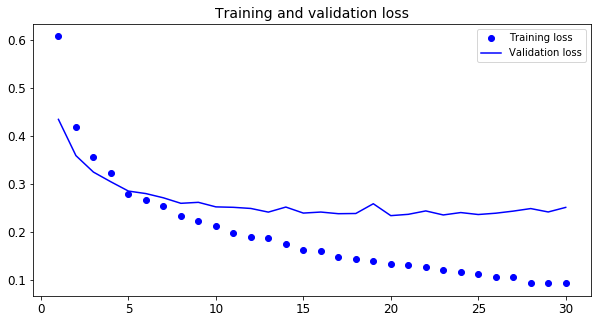

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy", fontsize=14)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss", fontsize=14)
plt.legend()

plt.show()

> 验证精度达到了90%左右，比从头开始训练的小型模型效果要好得多。虽然dropout比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

### 使用数据增强的特征提取

扩展`conv_base`模型，然后在输入数据上端到端地运行模型。可以在训练期间使用数据增强。

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


在编译和训练模型之前，一定要冻结卷积基（即在训练过程中保持其权重不变）。不这么做，卷积基之前学到的表示将会在训练过程中被修改。

**在keras中，冻结网络的方法是将其`trainalbe`属性设为`False`。**

In [11]:
# The number of trainable weights before freezing the conv base
len(model.trainable_weights)

30

In [12]:
# Freeze
conv_base.trainable = False
# The number of trainable weights after freezing the conv base
len(model.trainable_weights)

4

In [13]:
# 利用冻结的卷积基端到端地训练模型
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # 不能增强验证数据

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Compile
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# Fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 34s - loss: 0.5797 - acc: 0.7175 - val_loss: 0.4385 - val_acc: 0.8270
Epoch 2/30
 - 33s - loss: 0.4805 - acc: 0.7875 - val_loss: 0.3657 - val_acc: 0.8660
Epoch 3/30
 - 33s - loss: 0.4274 - acc: 0.8040 - val_loss: 0.3328 - val_acc: 0.8770
Epoch 4/30
 - 33s - loss: 0.4002 - acc: 0.8300 - val_loss: 0.3101 - val_acc: 0.8720
Epoch 5/30
 - 33s - loss: 0.3849 - acc: 0.8330 - val_loss: 0.3025 - val_acc: 0.8830
Epoch 6/30
 - 33s - loss: 0.3696 - acc: 0.8405 - val_loss: 0.2783 - val_acc: 0.8950
Epoch 7/30
 - 33s - loss: 0.3744 - acc: 0.8285 - val_loss: 0.2688 - val_acc: 0.8970
Epoch 8/30
 - 33s - loss: 0.3583 - acc: 0.8405 - val_loss: 0.2666 - val_acc: 0.8940
Epoch 9/30
 - 33s - loss: 0.3457 - acc: 0.8520 - val_loss: 0.2653 - val_acc: 0.8890
Epoch 10/30
 - 33s - loss: 0.3390 - acc: 0.8555 - val_loss: 0.2587 - val_acc: 0.9000
Epoch 11/30
 - 33s - loss: 0.3272 - acc: 0.8640 - val_loss: 0.2534 - val_ac

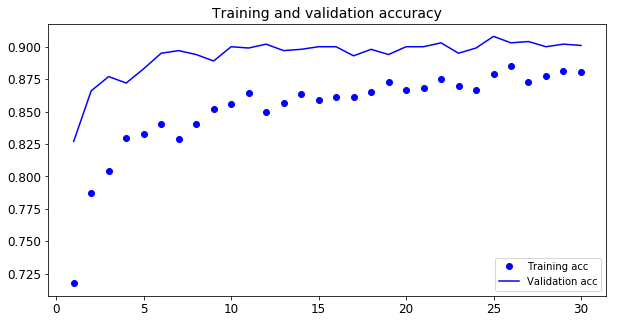

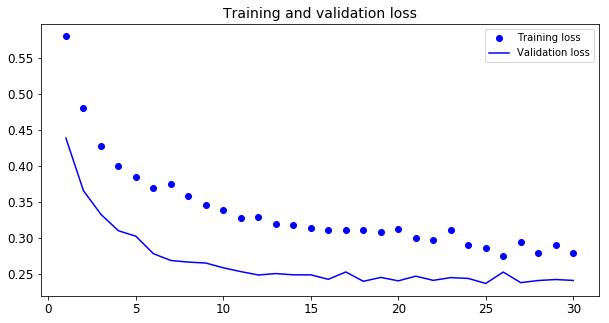

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy", fontsize=14)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss", fontsize=14)
plt.legend()

plt.show()

## 模型微调

与特征提取互为补充。对于用于特征提取的冻结的卷积基，微调是指将其顶部的几层解冻，并将这几层和新增加的部分联合训练。只是略微调整了所复用模型中更加抽象的表示，以便让这些表示和手头的任务更加相关。

1. 在已训练好的基网络（base network）添加自定义网络；
2. 冻结基网络；
3. 训练所添加的部分；
4. 解冻基网络的一些层；
5. 联合训练解冻的这些层和添加的部分。

In [16]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

微调最后三个卷积层，即block5_conv1、block5_conv2和block5_conv3。

In [19]:
conv_base.trainable

False

In [20]:
conv_base.layers

In [23]:
conv_base.layers[0].name

'input_1'

In [24]:
# 解冻直到某一层的所有层
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

使用学习率非常小的RMSprop优化器来实现。选学习率非常小，是因为对于微调的三层表示，希望其变化范围不要太大。太大的权重更新可能会破坏这些表示。

In [25]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/100
 - 39s - loss: 0.2977 - acc: 0.8750 - val_loss: 0.2150 - val_acc: 0.9180
Epoch 2/100
 - 38s - loss: 0.2664 - acc: 0.8920 - val_loss: 0.2079 - val_acc: 0.9160
Epoch 3/100
 - 38s - loss: 0.2326 - acc: 0.8985 - val_loss: 0.2413 - val_acc: 0.9060
Epoch 4/100
 - 38s - loss: 0.2268 - acc: 0.9075 - val_loss: 0.1917 - val_acc: 0.9220
Epoch 5/100
 - 38s - loss: 0.1954 - acc: 0.9160 - val_loss: 0.1988 - val_acc: 0.9240
Epoch 6/100
 - 38s - loss: 0.1939 - acc: 0.9180 - val_loss: 0.1785 - val_acc: 0.9310
Epoch 7/100
 - 38s - loss: 0.1690 - acc: 0.9310 - val_loss: 0.1779 - val_acc: 0.9320
Epoch 8/100
 - 38s - loss: 0.1910 - acc: 0.9215 - val_loss: 0.1876 - val_acc: 0.9270
Epoch 9/100
 - 38s - loss: 0.1581 - acc: 0.9370 - val_loss: 0.1997 - val_acc: 0.9310
Epoch 10/100
 - 38s - loss: 0.1591 - acc: 0.9330 - val_loss: 0.1861 - val_acc: 0.9350
Epoch 11/100
 - 38s - loss: 0.1509 - acc: 0.9320 - val_loss: 0.2054 - val_acc: 0.9320
Epoch 12/100
 - 38s - loss: 0.1297 - acc: 0.9525 - val_loss: 0.

Epoch 97/100
 - 38s - loss: 0.0228 - acc: 0.9915 - val_loss: 0.2307 - val_acc: 0.9410
Epoch 98/100
 - 38s - loss: 0.0251 - acc: 0.9920 - val_loss: 0.2532 - val_acc: 0.9360
Epoch 99/100
 - 38s - loss: 0.0132 - acc: 0.9950 - val_loss: 0.2960 - val_acc: 0.9360
Epoch 100/100
 - 38s - loss: 0.0197 - acc: 0.9925 - val_loss: 0.3617 - val_acc: 0.9260


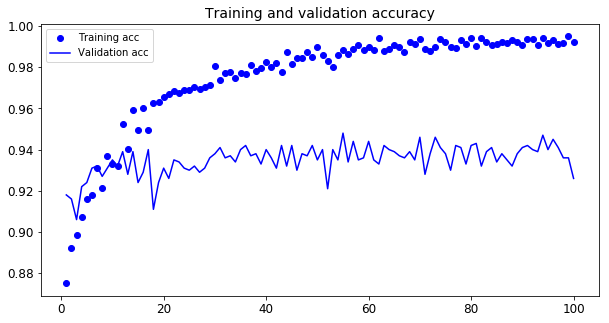

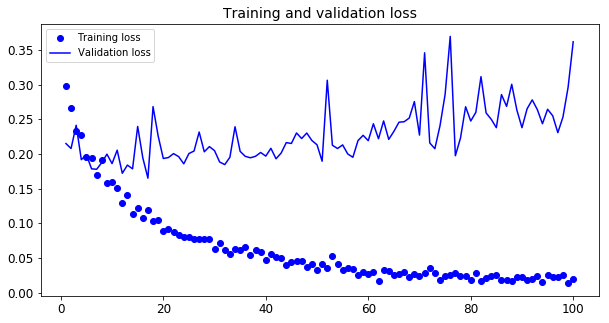

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy", fontsize=14)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss", fontsize=14)
plt.legend()

plt.show()

这些曲线看起来包含噪声。为使图像更具有可读性，可以将每个损失和精度都替换为指数移动平局值，从而让曲线变得更平滑。

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * 0.8 + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

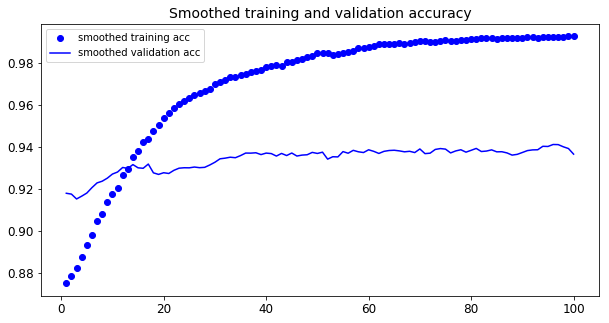

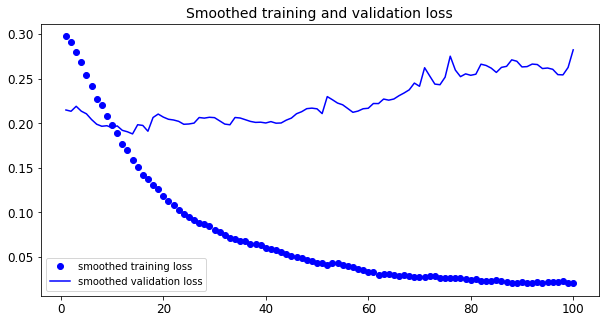

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, smooth_curve(acc), 'bo', label='smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='smoothed validation acc')
plt.title("Smoothed training and validation accuracy", fontsize=14)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(epochs, smooth_curve(loss), 'bo', label="smoothed training loss")
plt.plot(epochs, smooth_curve(val_loss), 'b', label="smoothed validation loss")
plt.title("Smoothed training and validation loss", fontsize=14)
plt.legend()

plt.show()

In [31]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test acc:", test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9219999897480011
